# Pet project broad games rating EDA

Цель данного проекта обучить модель машинного обучения для предсказания рейтинга настольных игр. Для тренировки и определения качества модели будем использовать [датасет с Kaggle](https://www.kaggle.com/datasets/andrewmvd/board-games?resource=download), в котором приводится статистика c BoardGameGeek по состоянию на февраль 2021 года. 
В качестве метрики будем испотльзовать MSE.

## Предообработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ROW_DATA_PATH = r'..\data\raw\bgg_dataset.csv'

Откроем датасет и выведем первые и последние 5 строк

In [3]:
df = pd.read_csv(ROW_DATA_PATH, sep=';')

In [4]:
df.head(5)

ID                               Name  Year Published  Min Players  \
0  174430.0                         Gloomhaven          2017.0            1   
1  161936.0          Pandemic Legacy: Season 1          2015.0            2   
2  224517.0                  Brass: Birmingham          2018.0            2   
3  167791.0                  Terraforming Mars          2016.0            1   
4  233078.0  Twilight Imperium: Fourth Edition          2017.0            3   

   Max Players  Play Time  Min Age  Users Rated Rating Average  BGG Rank  \
0            4        120       14        42055           8,79         1   
1            4         60       13        41643           8,61         2   
2            4        120       14        19217           8,66         3   
3            5        120       12        64864           8,43         4   
4            6        480       14        13468           8,70         5   

  Complexity Average  Owned Users  \
0               3,86      68323.0   
1               2,84      65294.0   
2               3,91      28785.0   
3               3,24      87099.0   
4               4,22      16831.0   

                                           Mechanics  \
0  Action Queue, Action Retrieval, Campaign / Bat...   
1  Action Points, Cooperative Game, Hand Manageme...   
2  Hand Management, Income, Loans, Market, Networ...   
3  Card Drafting, Drafting, End Game Bonuses, Han...   
4  Action Drafting, Area Majority / Influence, Ar...   

                          Domains  
0  Strategy Games, Thematic Games  
1  Strategy Games, Thematic Games  
2                  Strategy Games  
3                  Strategy Games  
4  Strategy Games, Thematic Games

In [5]:
df.tail(5)

ID                Name  Year Published  Min Players  Max Players  \
20338  16398.0                 War             0.0            2            2   
20339   7316.0               Bingo          1530.0            2           99   
20340   5048.0          Candy Land          1949.0            2            4   
20341   5432.0  Chutes and Ladders          -200.0            2            6   
20342  11901.0         Tic-Tac-Toe         -1300.0            2            2   

       Play Time  Min Age  Users Rated Rating Average  BGG Rank  \
20338         30        4         1340           2,28     20340   
20339         60        5         2154           2,85     20341   
20340         30        3         4006           3,18     20342   
20341         30        3         3783           2,86     20343   
20342          1        4         3275           2,68     20344   

      Complexity Average  Owned Users  \
20338                  1        427.0   
20339               1,05       1533.0   
20340               1,08       5788.0   
20341               1,02       4400.0   
20342               1,16       1374.0   

                                               Mechanics  \
20338                                                NaN   
20339   Betting and Bluffing, Bingo, Pattern Recognition   
20340                               Roll / Spin and Move   
20341  Dice Rolling, Grid Movement, Race, Roll / Spin...   
20342                 Paper-and-Pencil, Pattern Building   

                                Domains  
20338                  Children's Games  
20339                       Party Games  
20340                  Children's Games  
20341                  Children's Games  
20342  Abstract Games, Children's Games

В датасете есть следующие столцы:
 - ID - ID игры у BoardGamesGeek 
 - Name - Название настольной игры
 - Year Published - Год издания
 - Min Players - Минимум игроков
 - Max Players - Максимум игроков
 - Play Time - Среднее время игры, предложенное создателями игры
 - Min Age - минимальный рекомендуемый возраст
 - Users Rated - Количество пользователей, оценивших игру
 - Rating Average - Средний рейтинг
 - BGG Rank - рэйтинг BoardGamesGeek
 - Complexity Average - Средняя сложность
 - Owned Users - Количество пользователей купившые игру
 - Mechanics - Механики игры
 - Domains - Жанр

Выведем информацию по столбцам

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB


У столбцов Rating Average и Complexity Average неверный тип данных (должен быть float). Приведём их типы в порядок

In [7]:
df['Rating Average'] = df['Rating Average'].str.replace(',','.').astype('float')
df['Complexity Average'] = df['Complexity Average'].str.replace(',','.').astype('float')

Также у Owned Users и Year Published  должен быть тип int. Но при этом в данной колонке есть пропуски. Поскольку таких строк мало удалим их (В дальнейшем для ваидационной выборки такие строки нужно будет заполнить нулями). После чего приведём значения в данном столбце к типу int.

In [8]:
df = df.dropna(subset=['Year Published', 'Owned Users'])
df['Year Published'] = df['Year Published'].astype('int')
df['Owned Users'] = df['Owned Users'].astype('int')

Выведем информацию по числовым признакам

In [9]:
df.describe()

ID  Year Published   Min Players   Max Players  \
count   20320.000000    20320.000000  20320.000000  20320.000000   
mean   108210.740748     1984.226230      2.019636      5.673327   
std     98678.347583      214.117399      0.690545     15.239657   
min         1.000000    -3500.000000      0.000000      0.000000   
25%     11035.250000     2001.000000      2.000000      4.000000   
50%     88928.000000     2011.000000      2.000000      4.000000   
75%    192924.750000     2016.000000      2.000000      6.000000   
max    331787.000000     2022.000000     10.000000    999.000000   

          Play Time       Min Age    Users Rated  Rating Average  \
count  20320.000000  20320.000000   20320.000000    20320.000000   
mean      91.326772      9.600246     841.778691        6.403363   
std      545.749554      3.645790    3513.464339        0.935762   
min        0.000000      0.000000      30.000000        1.050000   
25%       30.000000      8.000000      55.000000        5.820000   
50%       45.000000     10.000000     120.000000        6.430000   
75%       90.000000     12.000000     385.000000        7.030000   
max    60000.000000     25.000000  102214.000000        9.580000   

           BGG Rank  Complexity Average    Owned Users  
count  20320.000000        20320.000000   20320.000000  
mean   10170.563976            1.990994    1408.457628  
std     5873.389392            0.849022    5040.179315  
min        1.000000            0.000000       0.000000  
25%     5084.750000            1.330000     146.000000  
50%    10168.500000            1.970000     309.000000  
75%    15258.250000            2.540000     864.000000  
max    20344.000000            5.000000  155312.000000

В ряде столбцов есть нули, при этом там не должно быть таких значений. Выведем такие строки столбцы.

In [10]:
df[df['Min Players']==0].head(5)

ID                                             Name  \
2625  37301.0                                          Decktet   
2839  18291.0                            Unpublished Prototype   
2988  21804.0                           Traditional Card Games   
3222  99358.0  Stonewall Jackson's Way II: Battles of Bull Run   
3587  23953.0                         Outside the Scope of BGG   

      Year Published  Min Players  Max Players  Play Time  Min Age  \
2625            2008            0            0         30        0   
2839               0            0            0          0        0   
2988               0            0            0          0        0   
3222            2013            0            2        720        0   
3587               0            0            0          0        0   

      Users Rated  Rating Average  BGG Rank  Complexity Average  Owned Users  \
2625          494            7.46      2627                2.00         1492   
2839          804            6.90      2841                2.47         1194   
2988          885            6.61      2990                1.95         1608   
3222          218            8.57      3224                3.74          699   
3587          580            6.68      3589                1.70         2670   

                       Mechanics                       Domains  
2625                         NaN                  Family Games  
2839                         NaN                Strategy Games  
2988                         NaN  Abstract Games, Family Games  
3222  Dice Rolling, Hexagon Grid                      Wargames  
3587                         NaN                  Family Games

В ряде случаев это информация либо о прототипах, либо обощения (наподобие традиционных карточных игр). Поэтому удалим строки в которых столбцы 'Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age' равны 0

In [11]:
df = df[(df['Year Published'] != 0) &
        (df['Min Players'] != 0) &
        (df['Max Players'] != 0) &
        (df['Play Time'] != 0) &
        (df['Year Published'] != 0)]

В столбцах 'Mechanics' и 'Domains' тодже есть пропуски, но поскольку данные столбцы текстовые и для их анализа будем использовать TfIdf, тозаполним пропуски в данных столбца пустой строкой

In [12]:
df['Mechanics'] = df['Mechanics'].fillna('')
df['Domains'] = df['Domains'].fillna('')

Часть столбцов является лишними и не несут информативной нагрузки:
- ID - поскольку является просто номером игры, то не несёт полезной информации
- Name - название настольной игры не очень информативно, поскольку может быть весьма абстрактно
- Users Rated - количество пользователей оценивших игру, может стать утечкой целевого  признака, поскольку по более популярным играм будет больше отзывов.
- BGG Rank - является рэйтингом игры по версии BGG и сотоветственно приведёт к утечке информации, поскольку будет частично перекликаться с целевым признаком.
Удалим данные столбцы

In [13]:
df = df.drop(['ID', 'Name', 'Users Rated', 'BGG Rank'], axis=1)

Повторно выведем информацию по оставшимся столбцам и убедимся, что всё отработало корректно

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19492 entries, 0 to 20342
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year Published      19492 non-null  int32  
 1   Min Players         19492 non-null  int64  
 2   Max Players         19492 non-null  int64  
 3   Play Time           19492 non-null  int64  
 4   Min Age             19492 non-null  int64  
 5   Rating Average      19492 non-null  float64
 6   Complexity Average  19492 non-null  float64
 7   Owned Users         19492 non-null  int32  
 8   Mechanics           19492 non-null  object 
 9   Domains             19492 non-null  object 
dtypes: float64(2), int32(2), int64(4), object(2)
memory usage: 1.5+ MB


Данные почищены и готовы к анализу

## Анализ данных

Рассмотрим как распределёна целевая переменная

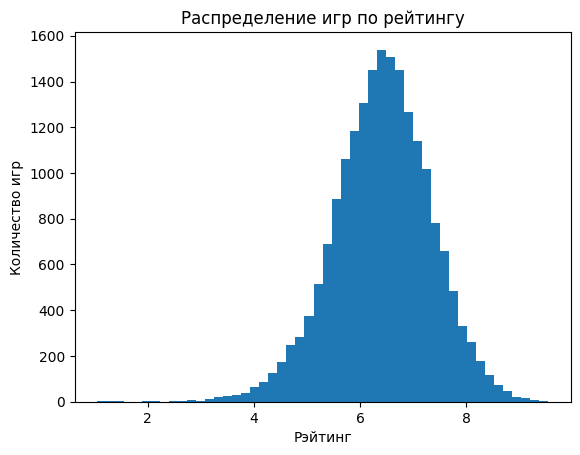

In [15]:
plt.hist(df['Rating Average'], bins=50)
plt.title('Распределение игр по рейтингу')
plt.xlabel('Рэйтинг')
plt.ylabel('Количество игр')
plt.show()

По графику видно, что целевая переменная имеет распределение близкое к нормальному с медианной в районе 6,5

Рассмотрим как распределены данные об играх по годам. Учитывая, что в датасете есть информация об очень древних играх, то будем рассматривать срез с 1950 года. Выведем гистограмму о количестве выпущенных игр.

In [16]:
plt.hist(df[df['Year Published']>=1950]['Year Published'], bins=25)
plt.title('Количество проданных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

По графику можно выделить несколько этапов популярности игр:
 - Не популярный (до 1950)
 - Малопопулярный (ориентировочно с 1951 по 1970)
 - Набирающий популярность (ориентировочно с 1971 по 2000)
 - Усиливающий популярность (ориентировочно с 2001 по 2014)
 - Очень популярный (ориентировочно с 2015)

Посмотрим как меняется средний рейтинг игры по годам

In [17]:
plt.scatter(df[df['Year Published']>=1950]['Year Published'], 
            df[df['Year Published']>=1950]['Rating Average'],
            alpha=0.6,
            s=10)
plt.title('Рэйтинг игр по годам')
plt.xlabel('Год')
plt.ylabel('Рэйтинг игр')
plt.show()

По рэйтингу также видно, что начиная 2012 игры становятся всё популярнее и получают более высокие рэйтинги.

In [18]:
plt.figure(figsize=(12,6))
plt.suptitle('Зависимость количества игр от')

ax1 = plt.subplot(131)
ax1.hist(df['Min Players'], bins=10)
ax1.set_title('минимального количества игроков')
ax1.set_ylabel('Количество игр')
ax1.set_xlabel('Мин. количества игроков')

ax2 = plt.subplot(132)
ax2.hist(df[df['Max Players']<20]['Max Players'], bins=20)
ax2.set_title('максимального количества игроков')
ax2.set_xlabel('Макс. количества игроков')

ax3 = plt.subplot(133)
ax3.hist(df[df['Play Time']<400]['Play Time'], bins=20)
ax3.set_title('времени на партию')
ax3.set_xlabel('Времени на партию')
plt.show()

По данным параметрам данные имеют выбросы и их желательно почистить на обучающей выборке. Нужно будет удалить игры в которых: 
- Минимальное количество играков больше 8
- Максимальное количество играков больше 12
- Время на партию больше 400 минут

Посмотрим как меняется средний рейтинг в зависиомсти от данных фичей

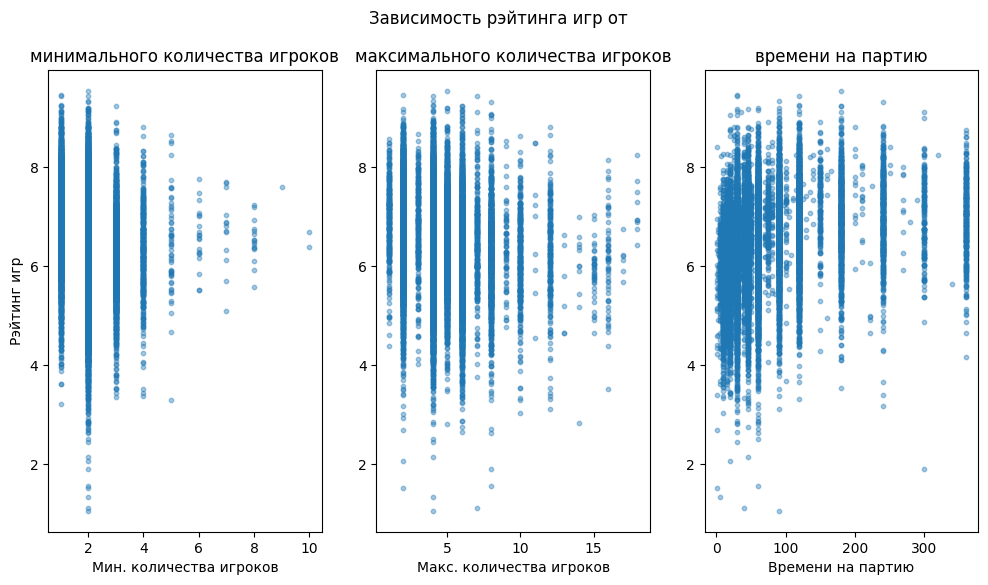

In [19]:
plt.figure(figsize=(12,6))
plt.suptitle('Зависимость рэйтинга игр от')

ax1 = plt.subplot(131)
ax1.scatter(df['Min Players'], 
            df['Rating Average'],
            alpha=0.4,
            s=10)
ax1.set_title('минимального количества игроков')
ax1.set_ylabel('Рэйтинг игр')
ax1.set_xlabel('Мин. количества игроков')

ax2 = plt.subplot(132)
ax2.scatter(df[df['Max Players']<20]['Max Players'], 
            df[df['Max Players']<20]['Rating Average'],
            alpha=0.4,
            s=10)
ax2.set_title('максимального количества игроков')
ax2.set_xlabel('Макс. количества игроков')

ax3 = plt.subplot(133)
ax3.scatter(df[df['Play Time']<400]['Play Time'], 
            df[df['Play Time']<400]['Rating Average'],
            alpha=0.4,
            s=10)
ax3.set_title('времени на партию')
ax3.set_xlabel('Времени на партию')
plt.show()

Явной зависимости по данным параметрам не наблюдается. Однако, при увеличении минимального количества играков свыше 4 значения максимального рейтинга падает, тоже самое наблюдается при максимальном количестве игроков в районе 12-14. Так же видно, что слишком короткие игры не так часто имеют высокие рейтинги.

Изучим влияние минимального возраста и средней сложности

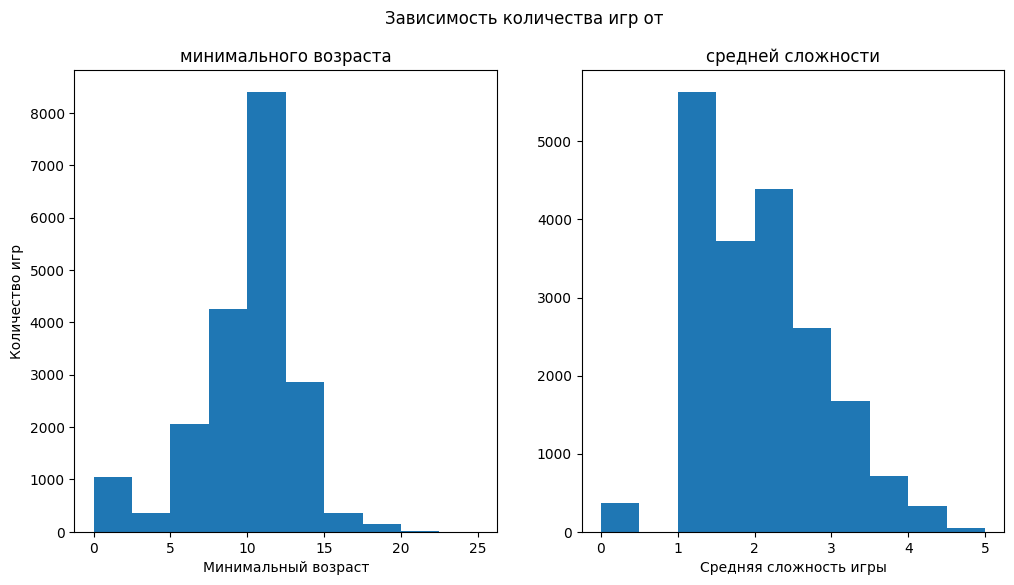

In [20]:
plt.figure(figsize=(12,6))
plt.suptitle('Зависимость количества игр от')

ax1 = plt.subplot(121)
ax1.hist(df['Min Age'], bins=10)
ax1.set_title('минимального возраста')
ax1.set_ylabel('Количество игр')
ax1.set_xlabel('Минимальный возраст')

ax2 = plt.subplot(122)
ax2.hist(df['Complexity Average'], bins=10)
ax2.set_title('средней сложности')
ax2.set_xlabel('Средняя сложность игры')
plt.show()

Распределение игр по минимальному возрасту носит нормальный характер с пиком в районе 12-13 лет. И небольшой выброс в районе 0.

По средней сложности идёт явное убывание, то есть чем сложнее игра, тем таких игр меньше

Рассмотрим как меняется рейтинг игр от данных параметров

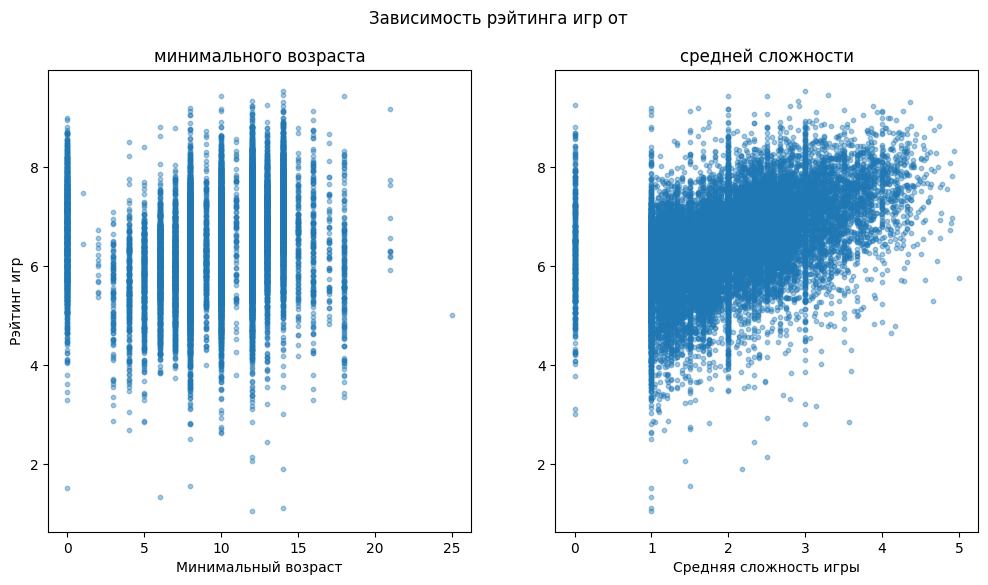

In [21]:
plt.figure(figsize=(12,6))
plt.suptitle('Зависимость рэйтинга игр от')

ax1 = plt.subplot(121)
ax1.scatter(df['Min Age'], 
            df['Rating Average'],
            alpha=0.4,
            s=10)
ax1.set_title('минимального возраста')
ax1.set_ylabel('Рэйтинг игр')
ax1.set_xlabel('Минимальный возраст')

ax2 = plt.subplot(122)
ax2.scatter(df['Complexity Average'], 
            df['Rating Average'],
            alpha=0.4,
            s=10)
ax2.set_title('средней сложности')
ax2.set_xlabel('Средняя сложность игры')

plt.show()

Средняя сложность игры имеет хорошо выраженную корреляцию с целевым признаком, кроме 0 значения, вероятнее всего это связано с отсутствием данных по этим играм, поэтому на обучающей выборке такие значения тоже нужно будет удалить удалить.

Исследуем, как влияет количество пользователей на количество экземпляров

In [22]:
plt.scatter(df['Owned Users'], 
            df['Rating Average'],
            alpha=0.6,
            s=10)
plt.title('Рэйтинг игр от количества проданных экземпляров')
plt.xlabel('Количества проданных экземпляров')
plt.ylabel('Рэйтинг игр')
plt.show()

Из графика видно, что при увеличении пользователей происходит смещение рейтинга игр ближе к  7,5 ... 8, однако данная информация является не совсем корректной, поскольку чем выше рейтинг игры, тем она популярнее и тем больше пользователей у неё будет, поэтому целесообразнее будет удалить данный столбец, так как данная информация будет не всегда и не всегда будет корректна.

## Выводы

Проведена предобработка данных в ходе которой сделано:

    1. Для ряда столбцов был изменён тип данных на правильный. при этом стоит отметить, что в некоорых столбцах в качестве десятичного разделителя стоит точка, в других - запятая.
    2. Удалены лишние строки, в которых содержалось слишком мало информации (всевозможное прототипы и обобщения игр, по которые сложно использовать для прогнозирования рэйтинга).
    3. Удалены лишние столбцы.
    4. Заполнены пропуски в описательных столбцах.
    
Проведён анализ данных в ходе которого установено:

    1. Что игры можно разделить на следующие этапы, в зависимости от года выпуска игры:
        - Не популярный (до 1950)
        - Малопопулярный (ориентировочно с 1951 по 1970)
        - Набирающий популярность (ориентировочно с 1971 по 2000)
        - Усиливающий популярность (ориентировочно с 2001 по 2014)
        - Очень популярный (ориентировочно с 2015)
        при этом данное разделение проссматривается как в количестве проданных игр, так и в рэйтинге.
    2. Были определены границы значения за пределами которых можно считать выбросами:
        - Минимальное количество играков не больше 8
        - Максимальное количество играков не больше 12
        - Время на партию не больше 400 минут
    3. Также было определено, что при увеличении минимального количества играков свыше 4 значения максимальных рейтинг падает, также видно, что слишком короткие игры не так часто имеют высокие рейтинги.
    4. Средняя сложность игры сильно коррелирует с целевым признаком, кроме 0 значения, вероятнее всего это связано с отсутствием данных по этим играм, поэтому на обучающей выборке такие значения тоже нужно будет удалить удалить.